In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install jcopdl==1.1.10

  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.10-py2.py3-none-any.whl size=17913 sha256=b7087ec9e97648459a5ba9d5a1aad0a5790f736dbef566de125cedf0ca7c33c0
  Stored in directory: /root/.cache/pip/wheels/41/95/30/86345d2446be19c7d97dee789a2597bee81cfbb7b24a847f7c
Successfully built jcopdl


Import Library yang digunakan

In [4]:
import jcopdl
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

Configurasi Device

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

Dataset dan data loader

In [7]:
#define trasnforms
bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size,scale=(0.7, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(227),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#load the dataset
train_set = datasets.ImageFolder("/content/drive/MyDrive/Colab Notebooks/ASIKGASIK", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

val_set = datasets.ImageFolder("/content/drive/MyDrive/Colab Notebooks/ASIKGASIK", transform=val_transform)
valloader = DataLoader(val_set, batch_size=bs, shuffle=True)

In [8]:
label2cat = train_set.classes
label2cat

['Crabs',
 'Dolphin',
 'Fish',
 'Jelly Fish',
 'Octopus',
 'Sharks',
 'Shrimp',
 'Squid',
 'Starfish',
 'Whale']

Arsitektur dan config

In [9]:
# Load arsitektur VGG16 dan Freeze weights
from torch.nn.modules import dropout
from torchvision.models import vgg16
mnet = vgg16(pretrained=True)
for param in mnet.parameters():
    param.requires_grad = False

# Configurasi Arsitektur VGG16 (Fully Connected Layer)
mnet.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(4096, 6)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:10<00:00, 51.3MB/s]


In [10]:
mnet

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
class Customvgg16(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = vgg16(pretrained=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
                nn.Linear(25088, 4096),
                nn.ReLU(True),
                nn.Dropout(0.5),
                nn.Linear(4096, 4096),
                nn.ReLU(True),
                nn.Dropout(0.5),
                nn.Linear(4096, output_size)
            )

    def forward(self, x):
        return self.mnet(x)
    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False
    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

In [12]:
config = set_config({
    "output_size": len(train_set.classes),
    "batch_size" : bs,
    "crop_size" : crop_size
})

Phase 1: Adaptation (learning rate 0.0001)

In [13]:
model = Customvgg16(config.output_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [14]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "val":
        model.eval()
    cost = correct = 0
    # Move tensors to the configured device
    for feature, target in dataloader:
        feature, target = feature.to(device), target.to(device)
        # Forward pass
        output = model(feature)
        loss = criterion(output, target)
        # Backward and optimize
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [15]:
#Validation
epochs = 15
train_cost, val_cost = [], []
train_acc, val_acc = [], []
for i in range (epochs):
  cost, acc = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
  train_cost.append(cost)
  train_acc.append(acc)
  with torch.no_grad():
      cost, acc = loop_fn("val", val_set, valloader, model, criterion, optimizer, device)
      val_cost.append(cost)
      val_acc.append(acc)
  print(f"Epoch: {i+1}/{epochs} | train_cost: {train_cost[-1]:.4f} | val_cost: {val_cost[-1]:.4f} | "
        f" train_acc: {train_acc[-1]:.4f} | val_acc: {val_acc[-1]:.4f}")

Epoch: 1/15 | train_cost: 3.1209 | val_cost: 0.5401 |  train_acc: 0.5034 | val_acc: 0.8167
Epoch: 2/15 | train_cost: 0.6588 | val_cost: 0.3539 |  train_acc: 0.7845 | val_acc: 0.8940
Epoch: 3/15 | train_cost: 0.4850 | val_cost: 0.2417 |  train_acc: 0.8440 | val_acc: 0.9289
Epoch: 4/15 | train_cost: 0.4345 | val_cost: 0.1944 |  train_acc: 0.8762 | val_acc: 0.9350
Epoch: 5/15 | train_cost: 0.3723 | val_cost: 0.1281 |  train_acc: 0.8762 | val_acc: 0.9596
Epoch: 6/15 | train_cost: 0.3390 | val_cost: 0.1383 |  train_acc: 0.8947 | val_acc: 0.9651
Epoch: 7/15 | train_cost: 0.2773 | val_cost: 0.1117 |  train_acc: 0.9090 | val_acc: 0.9665
Epoch: 8/15 | train_cost: 0.2897 | val_cost: 0.0695 |  train_acc: 0.9001 | val_acc: 0.9802
Epoch: 9/15 | train_cost: 0.2705 | val_cost: 0.0940 |  train_acc: 0.9220 | val_acc: 0.9713
Epoch: 10/15 | train_cost: 0.2768 | val_cost: 0.0945 |  train_acc: 0.9077 | val_acc: 0.9767
Epoch: 11/15 | train_cost: 0.3413 | val_cost: 0.1084 |  train_acc: 0.9186 | val_acc: 0.97

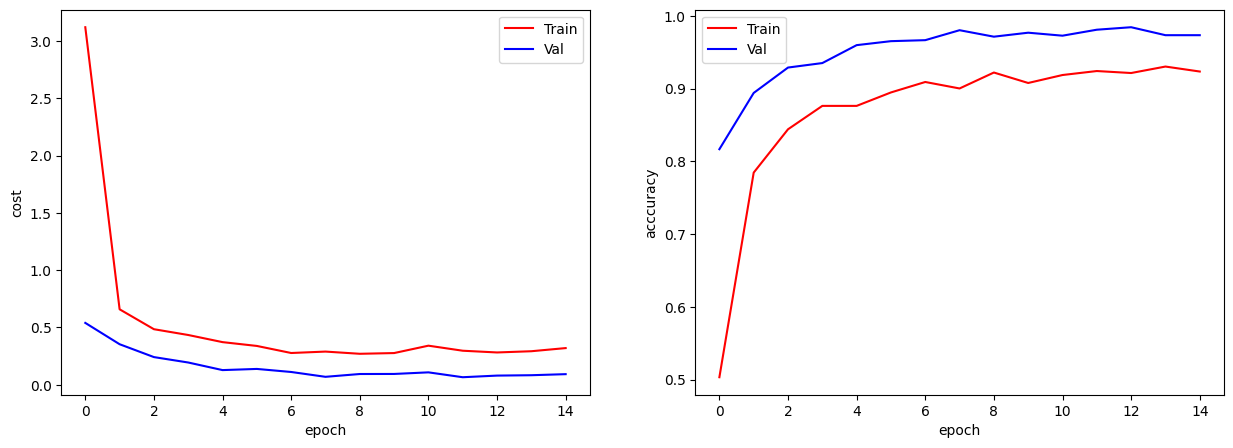

In [16]:
#Plotting
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(train_cost, 'r-', label='Train')
plt.plot(val_cost, 'b-', label='Val')
plt.xlabel("epoch"); plt.ylabel("cost"); plt.legend();

plt.subplot(122)
plt.plot(train_acc, 'r-', label='Train')
plt.plot(val_acc, 'b-', label='Val')
plt.xlabel("epoch"); plt.ylabel("acccuracy"); plt.legend();

Phase 2 : Fine Tuning (Learning rate dikecilin)

In [17]:
#unfreeze weights
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

In [18]:
#validation
epochs = 20
train_cost, val_cost = [], []
train_acc, val_acc = [], []
for i in range (epochs):
  cost, acc = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
  train_cost.append(cost)
  train_acc.append(acc)
  with torch.no_grad():
      cost, acc = loop_fn("val", val_set, valloader, model, criterion, optimizer, device)
      val_cost.append(cost)
      val_acc.append(acc)
  print(f"Epoch: {i+1}/{epochs} | train_cost: {train_cost[-1]:.4f} | val_cost: {val_cost[-1]:.4f} | "
        f" train_acc: {train_acc[-1]:.4f} | val_acc: {val_acc[-1]:.4f}")

Epoch: 1/20 | train_cost: 0.2604 | val_cost: 0.0516 |  train_acc: 0.9268 | val_acc: 0.9850
Epoch: 2/20 | train_cost: 0.1960 | val_cost: 0.0292 |  train_acc: 0.9391 | val_acc: 0.9932
Epoch: 3/20 | train_cost: 0.1564 | val_cost: 0.0357 |  train_acc: 0.9460 | val_acc: 0.9918
Epoch: 4/20 | train_cost: 0.1480 | val_cost: 0.0282 |  train_acc: 0.9528 | val_acc: 0.9932
Epoch: 5/20 | train_cost: 0.1333 | val_cost: 0.0234 |  train_acc: 0.9610 | val_acc: 0.9952
Epoch: 6/20 | train_cost: 0.1137 | val_cost: 0.0309 |  train_acc: 0.9624 | val_acc: 0.9938
Epoch: 7/20 | train_cost: 0.1141 | val_cost: 0.0303 |  train_acc: 0.9665 | val_acc: 0.9945
Epoch: 8/20 | train_cost: 0.1091 | val_cost: 0.0289 |  train_acc: 0.9679 | val_acc: 0.9952
Epoch: 9/20 | train_cost: 0.1203 | val_cost: 0.0189 |  train_acc: 0.9637 | val_acc: 0.9952
Epoch: 10/20 | train_cost: 0.0801 | val_cost: 0.0167 |  train_acc: 0.9733 | val_acc: 0.9966
Epoch: 11/20 | train_cost: 0.0787 | val_cost: 0.0152 |  train_acc: 0.9761 | val_acc: 0.99

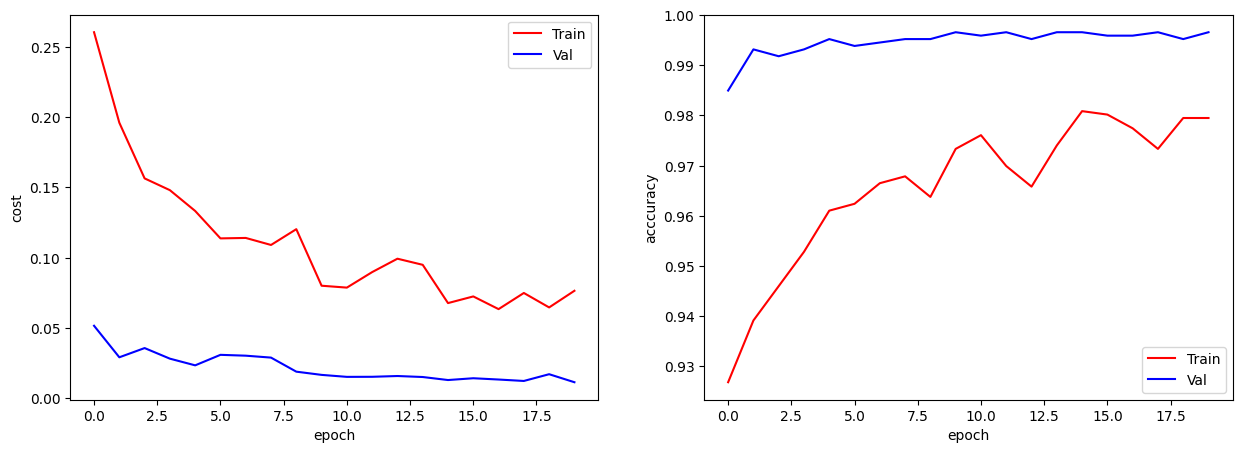

In [19]:
#Plotting
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(train_cost, 'r-', label='Train')
plt.plot(val_cost, 'b-', label='Val')
plt.xlabel("epoch"); plt.ylabel("cost"); plt.legend();

plt.subplot(122)
plt.plot(train_acc, 'r-', label='Train')
plt.plot(val_acc, 'b-', label='Val')
plt.xlabel("epoch"); plt.ylabel("acccuracy"); plt.legend();

Prediksi

In [20]:
feature, target = next(iter(valloader))
feature, target = feature.to(device), target.to(device)

In [21]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([2, 0, 2, 6, 9, 1, 0, 7, 0, 1, 6, 1, 0, 2, 1, 5, 0, 0, 0, 8, 0, 3, 4, 0,
        1, 8, 7, 0, 1, 0, 9, 1, 6, 6, 0, 4, 4, 0, 8, 5, 3, 9, 2, 6, 8, 1, 0, 7,
        1, 6, 8, 7, 6, 1, 9, 1, 1, 3, 1, 1, 9, 0, 1, 2], device='cuda:0')

Sanity Check

In [22]:
#inverse Images
def inverse_norm(img):
    img[0, :, :] = img[0, :, :] = 0.229 + 0.485
    img[1, :, :] = img[1, :, :] = 0.224 + 0.456
    img[2, :, :] = img[2, :, :] = 0.225 + 0.406
    return img

In [23]:
#plot images hasil prediksi
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred =label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | p: {pred}", fontdict=font);
    ax.axis('off');

Output hidden; open in https://colab.research.google.com to view.

In [24]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/ASIKGASIK.pth')

In [4]:
from torchvision import transforms
from PIL import Image

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function untuk upload gambar
def process_uploaded_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = test_transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# contoh gambar:
uploaded_image_path = "/content/54403656_01419609db_b.jpg"
uploaded_image = process_uploaded_image(uploaded_image_path)

In [26]:
# Menghitung persentase akurasi
final_val_accuracy = val_acc = [0.8222, 0.8947, 0.9337, 0.9330, 0.9596, 0.9672, 0.9672, 0.9720, 0.9665, 0.9815, 0.9802, 0.9788, 0.9761, 0.9904, 0.9843]

In [27]:
# Menghitung persentase akurasi
final_val_accuracy = val_acc[-1] * 100

# Menampilkan akurasi
print(f"Akurasi Validasi Akhir: {final_val_accuracy:.2f}%")

Akurasi Validasi Akhir: 98.43%
